<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
$\beta\beta0\nu$ Reco </p><br>

## Documents $\beta\beta0\nu$ reconstruction functions in NextFlex

In [1]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [2]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [3]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [6]:
idx = pd.IndexSlice

#### IC

In [7]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [8]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

#### NetFlex

In [9]:
from nextflex.core import Setup

In [10]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [43]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy
from nextflex.reco_analysis import reco_gtrack_blobs

In [42]:
from nextflex.reco_analysis import gtrack_summary

### Input data

In [12]:
FDATA = os.environ['FLEXDATA']

### test file

In [13]:
testFile      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.0.next.h5')

### Get hits from MC

In [14]:
mcHits = get_mc_hits(testFile)
mcHits

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [15]:
mcHits.df

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
3        83631883    77      361.853577   76.278801  991.085022  0.180530   
                     78      361.854279   76.278984  991.085205  0.180554   
                     79      361.854858   76.279205  991.085327  0.180574   
                     80      361.854950   76.279205  991.085815  0.180591   
                     81      361.854919   76.279099  991.086670  0.180629   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
3        83631883    77      0.000109  ACTIVE  
                     78      0.000363  ACTIVE  
                     79      0.000117  ACTIVE  
                     80      0.000899  ACTIVE  
                     81      0.001552  ACTIVE  

[2319 rows x 6 columns]

In [16]:
mcHits.event_list()

array([0, 1, 2, 3])

#### all hits

In [17]:
mchits = get_event_hits_from_mchits(mcHits, event_id=0, hit_type='all')

In [18]:
mchits

<EventHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy')
        

In [19]:
mchits.df.energy.sum()

2.4578302

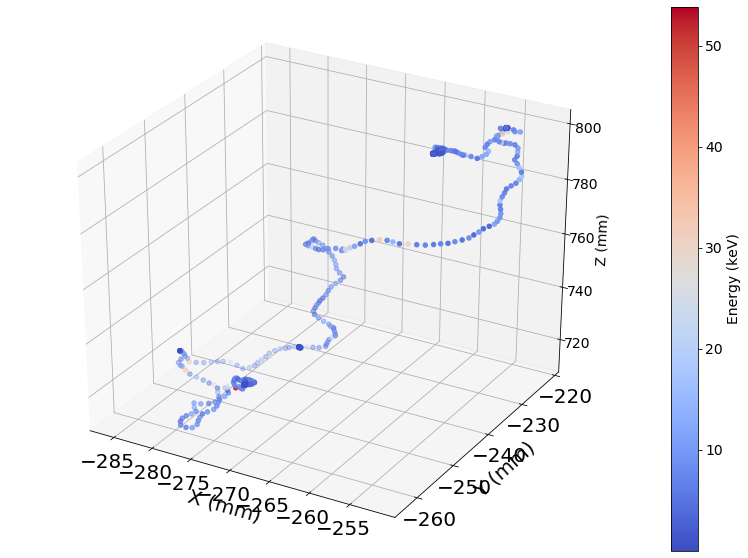

In [20]:
plot_hits3d(mchits.df, autorange = True, figsize   = (14,10))

### Voxelize

- To voxelize a set of hits (defined by x,y,z,energy), one needs to do the following:
    - Define voxels (e.g, cubic volumes) by dividing the space in 3d bins 
    - Group all the hits contained in the voxel. 

- The voxel has fields (x,y,z,energy, nhits), where nhits is the number of hits used to form the track and
the (x,y,z) of the voxels are the barycenters of the hits: e.g, 

$x_v = \frac{\sum x_i e_i}{\sum e_i}$, where:

$x_v=(x,y,z)$ of the voxel

$x_i=(x,y,z)$ of each hit in the voxel, $e_i$ is the energy of each hit in the voxel

The energy of the voxel is the sum of the energies of the hits, $e_v = \sum e_i$

#### Using barycenter to define the hit position

In [26]:
vt12 = voxelize_hits(mchits, bin_size = 5, baryc = True)
vt12df = vt12.df

In [27]:
vt12df.head()

,x,y,z,energy,nhits
0,-281.495445,-252.141319,717.871389,0.019912,2.0
1,-283.392537,-251.268818,720.133366,0.085471,8.0
2,-283.321740,-247.312412,716.628577,0.079895,7.0
3,-285.253782,-248.138173,719.995977,0.025327,11.0
4,-277.384746,-261.305064,714.858630,0.059130,8.0


In [28]:
len(vt12df)

44

#### Draw hits and voxelized hits

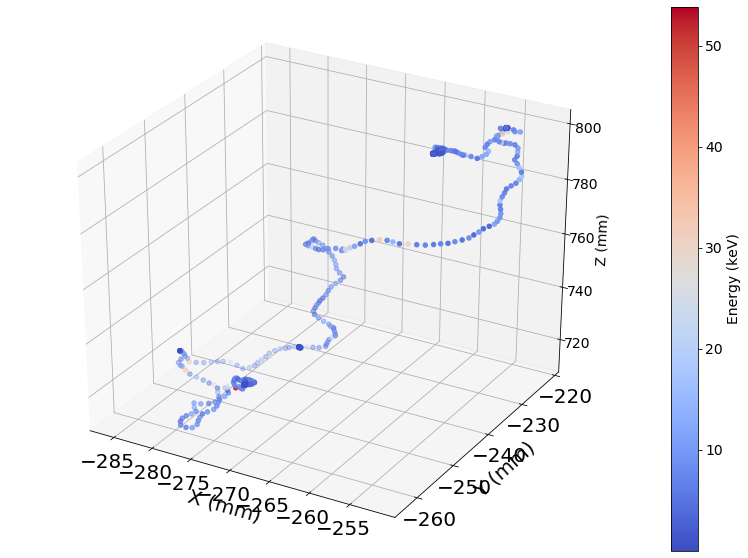

In [29]:
plot_hits3d(mchits.df, autorange = True, figsize   = (14,10))

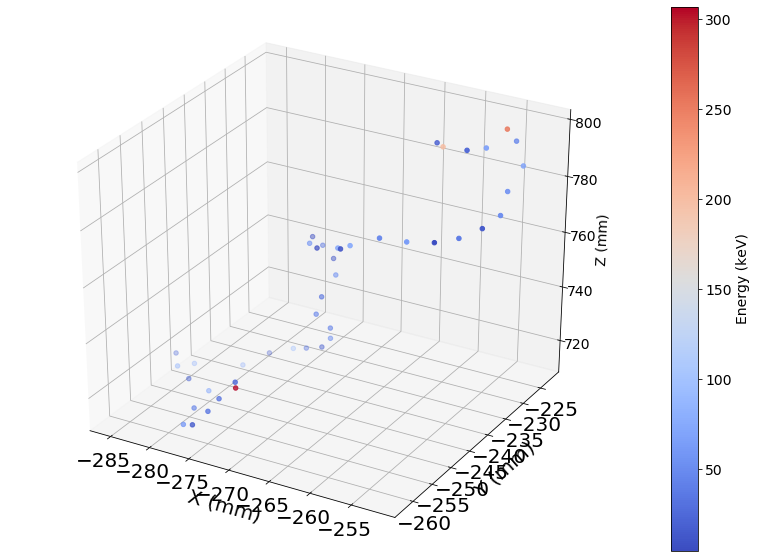

In [30]:
plot_hits3d(vt12df, autorange = True, figsize   = (14,10))

## Organise hits into a track

#### Compute inclusive distance between any pair of voxels and minimum distance between a voxel and any other voxel

In [31]:
voxels = get_voxels_as_list(vt12)

In [32]:
minimum_d, inclusive_d = voxel_distances(voxels)

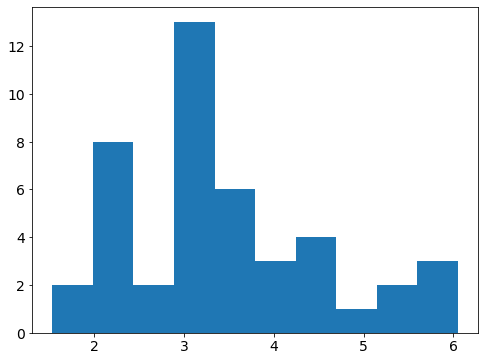

In [33]:
out = plt.hist(minimum_d)

### Define gtracks (graph tracks)

#### Contiguity of 10 mm 

In [34]:
contiguity = 10
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 10 is 1


In [35]:
gtv = gtrack_voxels(gtracks[0], event_id=0)
gtv

<VoxelHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy', 'nhits')
        

In [36]:
gtvdf = gtv.df

In [37]:
gtvdf.head()

,x,y,z,energy,nhits
0,-281.495445,-252.141319,717.871389,0.019912,2.0
1,-283.392537,-251.268818,720.133366,0.085471,8.0
2,-283.321740,-247.312412,716.628577,0.079895,7.0
3,-285.253782,-248.138173,719.995977,0.025327,11.0
4,-277.384746,-261.305064,714.858630,0.059130,8.0


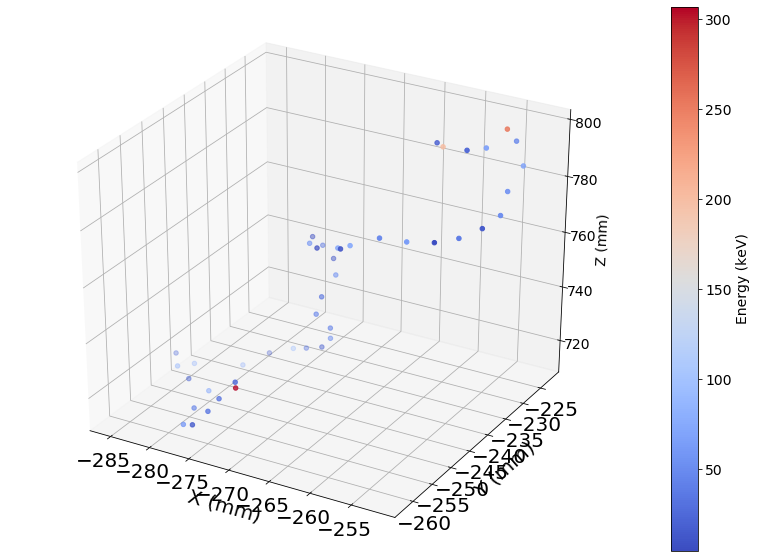

In [38]:
plot_hits3d(gtvdf, autorange = True, figsize   = (14,10))

### Create a GTrack object
- A gtrack takes a graph track and computes the extrema and track length. 

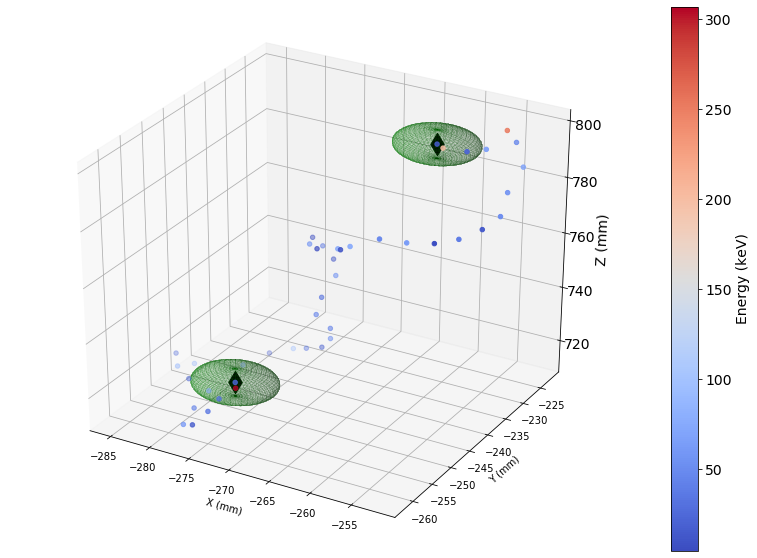

In [39]:
gt = GTrack(gtracks[0], event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [45]:
gtrks=[gt]

In [46]:
gts = reco_gtrack_blobs(gtrks, rb = 5)

In [47]:
gtrack_summary(gts,0)


    GTrack number = 0
    NumberOfVoxels    = 44
    TrackLength       = 134.50971365706997
    NumberVoxelsBlob1 = 2
    NumberVoxelsBlob2 = 3
    EnergyBlob1       = 332.2243131697178
    EnergyBlob2       = 239.8379910737276
    


### Event 1

In [48]:
mchits = get_event_hits_from_mchits(mcHits, event_id=mcHits.event_list()[1], hit_type='all')
vt12 = voxelize_hits(mchits, bin_size = 5, baryc = True)
vt12df = vt12.df
len(vt12df)

55

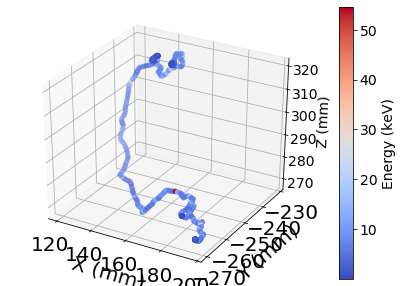

In [49]:
plot_hits3d(mchits.df, autorange = True, figsize   = (7,5))

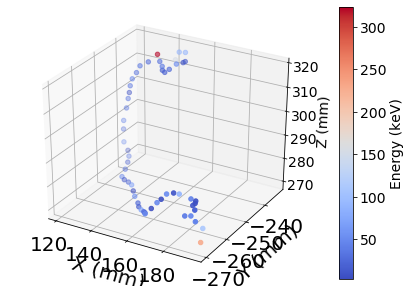

In [50]:
plot_hits3d(vt12df, autorange = True, figsize   = (7,5))

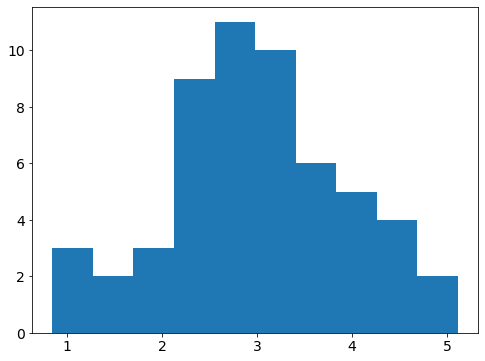

In [51]:
voxels = get_voxels_as_list(vt12)
minimum_d, _ = voxel_distances(voxels)
_ = plt.hist(minimum_d)

In [52]:
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 10 is 1


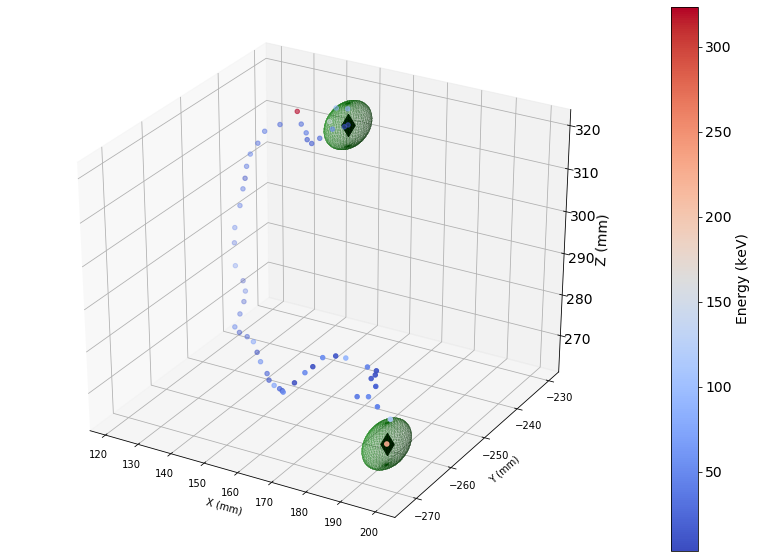

In [53]:
gt = GTrack(gtracks[0], event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [54]:
gtrks=[gt]
gts = reco_gtrack_blobs(gtrks, rb = 5)
gtrack_summary(gts,0)


    GTrack number = 0
    NumberOfVoxels    = 55
    TrackLength       = 149.103735166614
    NumberVoxelsBlob1 = 4
    NumberVoxelsBlob2 = 1
    EnergyBlob1       = 158.19250885397196
    EnergyBlob2       = 227.45442390441895
    


### Event 2

In [56]:
mchits = get_event_hits_from_mchits(mcHits, event_id=mcHits.event_list()[2], hit_type='all')
vt12 = voxelize_hits(mchits, bin_size = 5, baryc = True)
vt12df = vt12.df
len(vt12df)

57

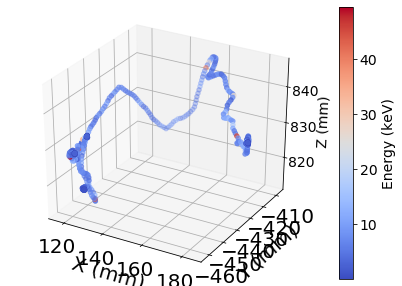

In [57]:
plot_hits3d(mchits.df, autorange = True, figsize   = (7,5))

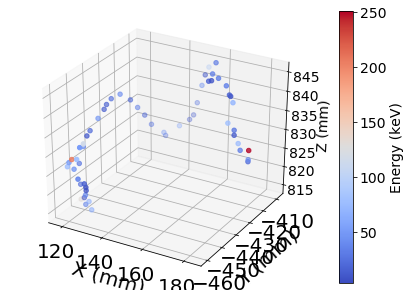

In [58]:
plot_hits3d(vt12df, autorange = True, figsize   = (7,5))

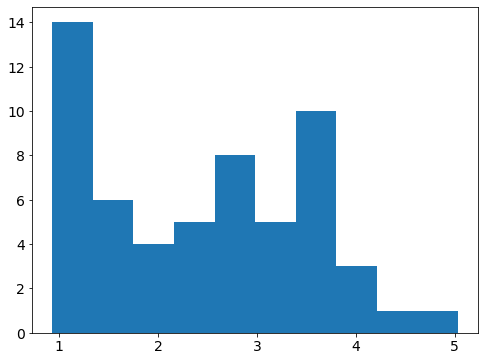

In [59]:
voxels = get_voxels_as_list(vt12)
minimum_d, _ = voxel_distances(voxels)
_ = plt.hist(minimum_d)

In [60]:
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 10 is 1


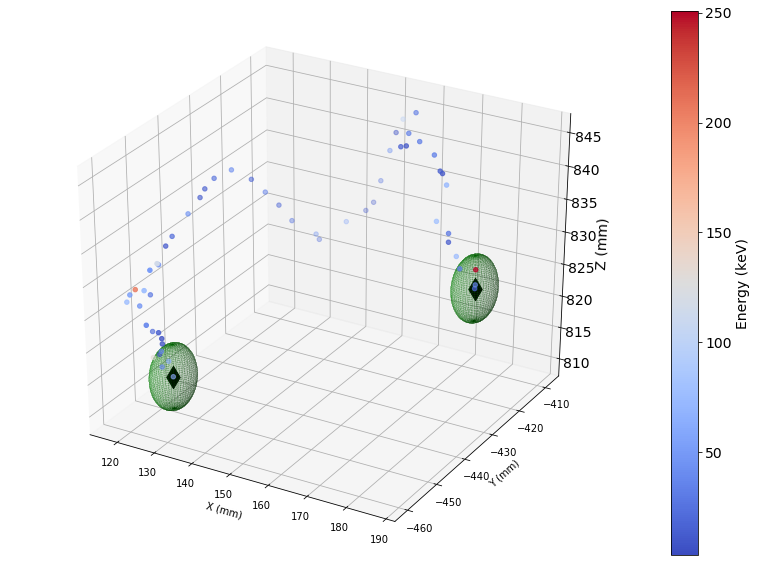

In [61]:
gt = GTrack(gtracks[0], event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [62]:
gtrks=[gt]
gts = reco_gtrack_blobs(gtrks, rb = 5)
gtrack_summary(gts,0)


    GTrack number = 0
    NumberOfVoxels    = 57
    TrackLength       = 127.19435435922342
    NumberVoxelsBlob1 = 4
    NumberVoxelsBlob2 = 4
    EnergyBlob1       = 195.7099884748459
    EnergyBlob2       = 338.929271325469
    


### Event 3

In [64]:
mchits = get_event_hits_from_mchits(mcHits, event_id=mcHits.event_list()[3], hit_type='all')
vt12 = voxelize_hits(mchits, bin_size = 5, baryc = True)
vt12df = vt12.df
len(vt12df)

48

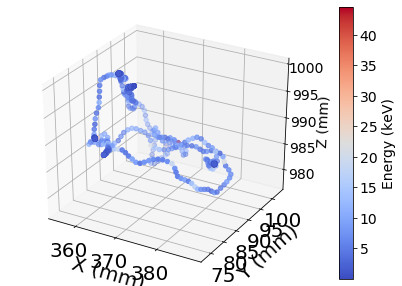

In [65]:
plot_hits3d(mchits.df, autorange = True, figsize   = (7,5))

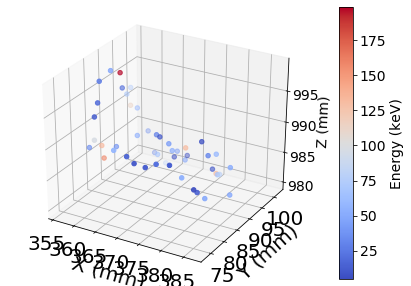

In [66]:
plot_hits3d(vt12df, autorange = True, figsize   = (7,5))

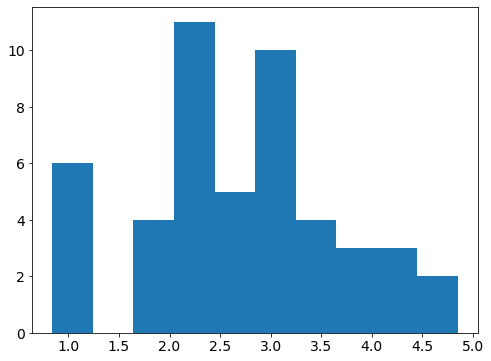

In [67]:
voxels = get_voxels_as_list(vt12)
minimum_d, _ = voxel_distances(voxels)
_ = plt.hist(minimum_d)

In [68]:
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 10 is 1


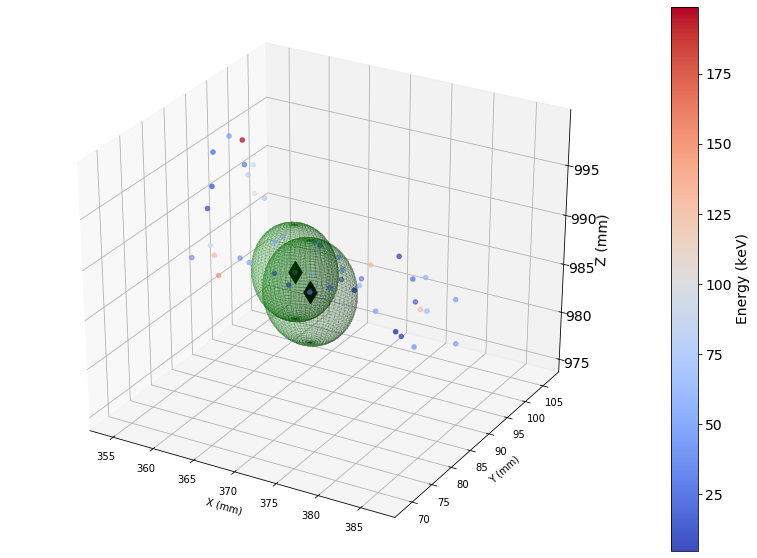

In [69]:
gt = GTrack(gtracks[0], event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [70]:
gtrks=[gt]
gts = reco_gtrack_blobs(gtrks, rb = 5)
gtrack_summary(gts,0)


    GTrack number = 0
    NumberOfVoxels    = 48
    TrackLength       = 48.47275604596081
    NumberVoxelsBlob1 = 3
    NumberVoxelsBlob2 = 5
    EnergyBlob1       = 141.86256751418114
    EnergyBlob2       = 71.4607685804367
    
